In [1]:
import sys
sys.path.append('/data/rradev/generator_reweight/')

# EOS being weird
!kinit rradev@CERN.CH -k -t rradev.keytab

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import latex
import numpy as np
import seaborn as sns
import argparse



from sklearn.metrics import classification_report
from utils.plotting import plot_distribution
from utils.funcs import calculate_weights

In [3]:
reweighted_samples_path = '/data/rradev/generator_reweight/reweighted_samples/'
col_names =  ["isNu", "isNue", "isNumu", "isNutau", "cc", "Enu_true", "ELep", "CosLep", "Q2", "W", "x", "y", "nP", "nN", "nipip", "nipim", "nipi0", "niem", "eP", "eN", "ePip", "ePim", "ePi0"]

def load_feats_logits():
    genie_feats = np.load(reweighted_samples_path + 'GENIEv2_features.npy')
    genie_logits = np.load(reweighted_samples_path + 'GENIEv2_logits.npy')
    genie = pd.DataFrame(genie_feats, columns=col_names)
    genie['logits'] = genie_logits
    genie['generator'] = 'genie'

    neut_feats = np.load(reweighted_samples_path + 'NUWRO_features.npy')
    neut_logits = np.load(reweighted_samples_path + 'NUWRO_logits.npy')
    neut = pd.DataFrame(neut_feats, columns=col_names)
    neut['logits'] = neut_logits
    neut['generator'] = 'neut'
    neut = neut[neut['ELep'] > 0]
    return neut, genie


In [29]:
manyBins = 100
vars_meta = np.array(
             [["isNu", 2, 0, 1, r"$\nu / \bar{\nu}$ flag"],
              ["isNue", 2, 0, 1, r"$\nu_{e}$ flag"],
              ["isNumu", 2, 0, 1, r"$\nu_{\mu}$ flag"],
              ["isNutau", 2, 0, 1, r"$\nu_{\tau}$ flag"],
              ["cc", 2, 0, 1, "CC flag"],
              ["Enu_true", manyBins, 0, 10, "Neutrino energy [GeV]"],
              ["ELep", manyBins, 0, 5, "Lepton energy [GeV]"],
              ["CosLep", manyBins, -1, 1, r"cos$\theta_{\ell}$"],
              ["Q2", manyBins, 0, 10, r"Q^2"],
              ["W", manyBins, 0, 5, r"W [GeV/$c^{2}$]"],
              ["x", manyBins, 0, 1, "x"],
              ["y", manyBins, 0, 1, "y"],
              ["nP", 15, 0, 15, "Number of protons"],
              ["nN", 15, 0, 15, "Number of neutrons"],
              ["nipip", 10, 0, 10, r"Number of $\pi^{+}$"],
              ["nipim", 10, 0, 10, r"Number of $\pi^{-}$"],
              ["nipi0", 10, 0, 10, r"Number of $\pi^{0}$"],
              ["niem", 10, 0, 10, r"Number of EM objects"],
              ["eP", manyBins-1, 1./manyBins , 5, "Total proton kinetic energy"],
              ["eN", manyBins-1, 1./manyBins, 5, "Total neutron kinetic energy"],
              ["ePip", manyBins-1, 1./manyBins, 5, r"Total $\pi^{+}$ kinetic energy"],
              ["ePim", manyBins-1, 1./manyBins, 5, r"Total $\pi^{-}$ kinetic energy"],
              ["ePi0", manyBins-1, 1./manyBins, 5, r"Total $\pi^{0}$ kinetic energy"]]).transpose()

col_names, n_bins, x_min, x_max, fig_title = vars_meta

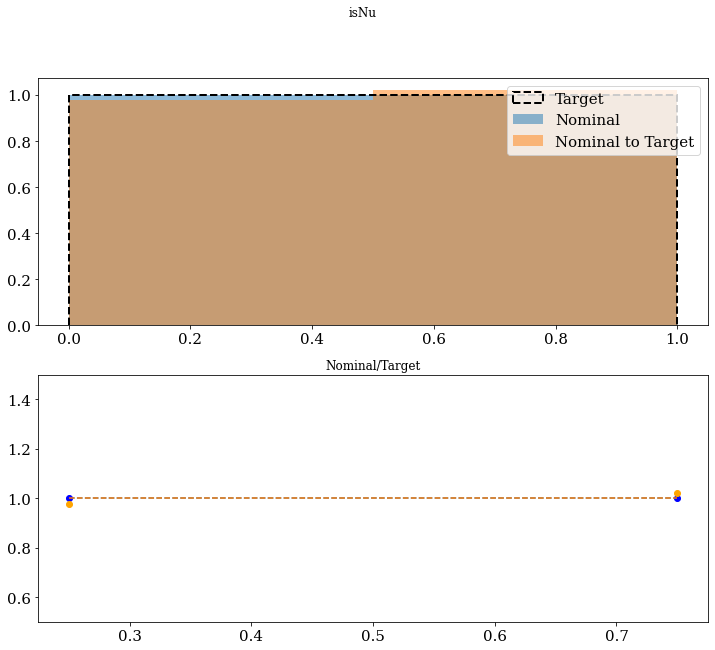

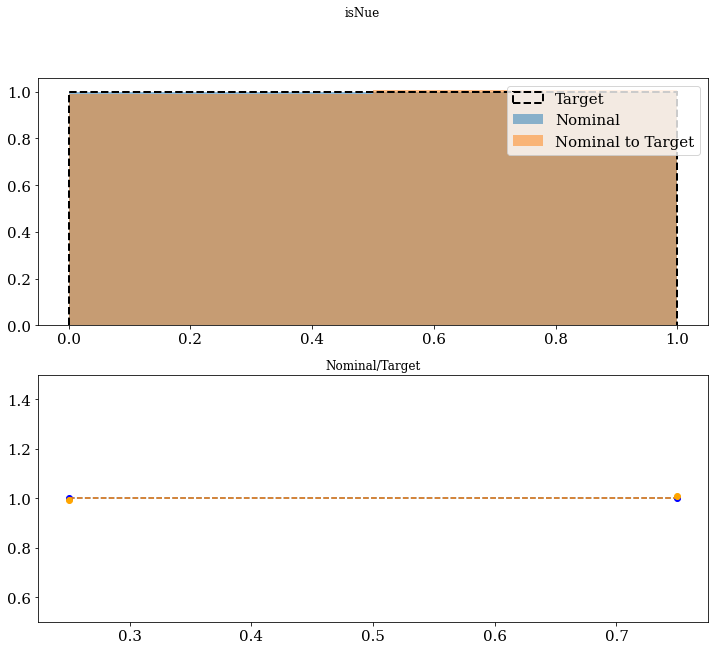

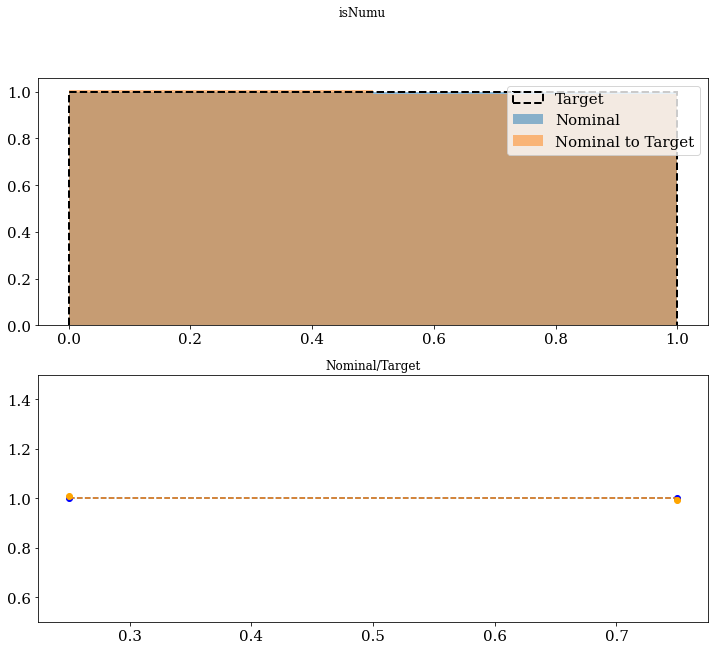

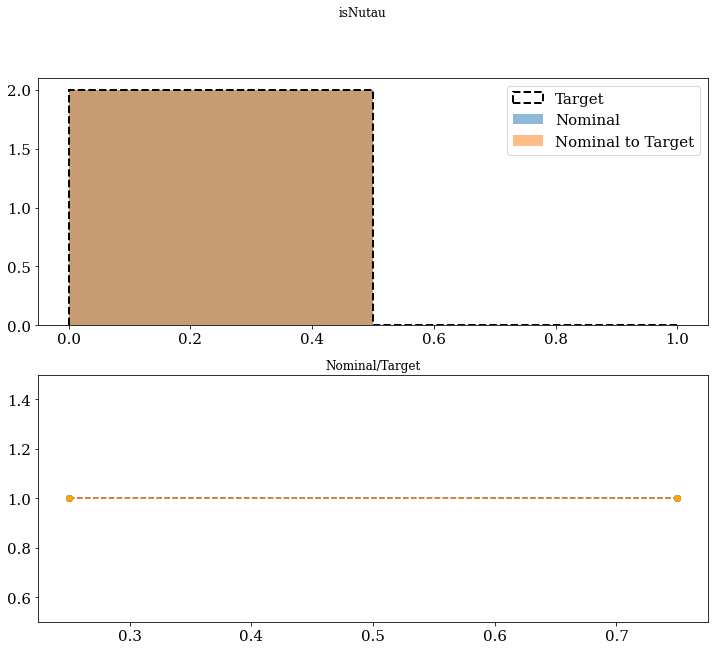

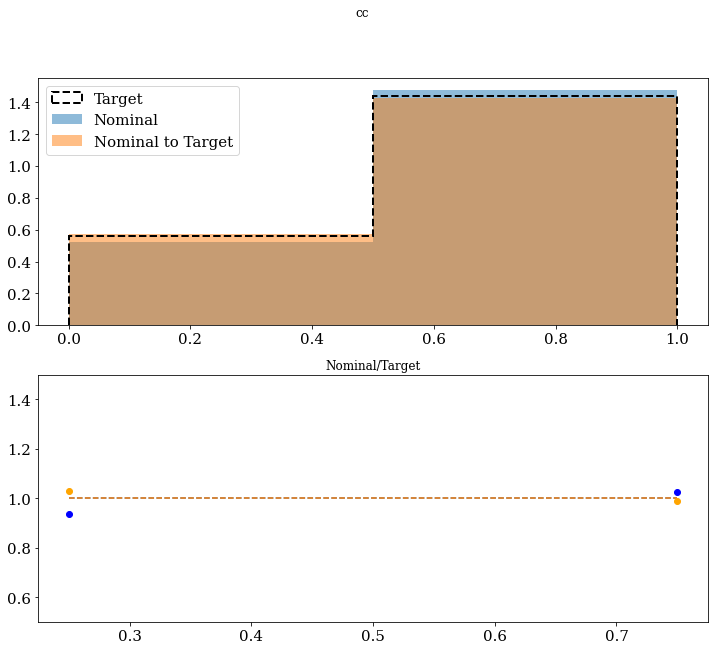

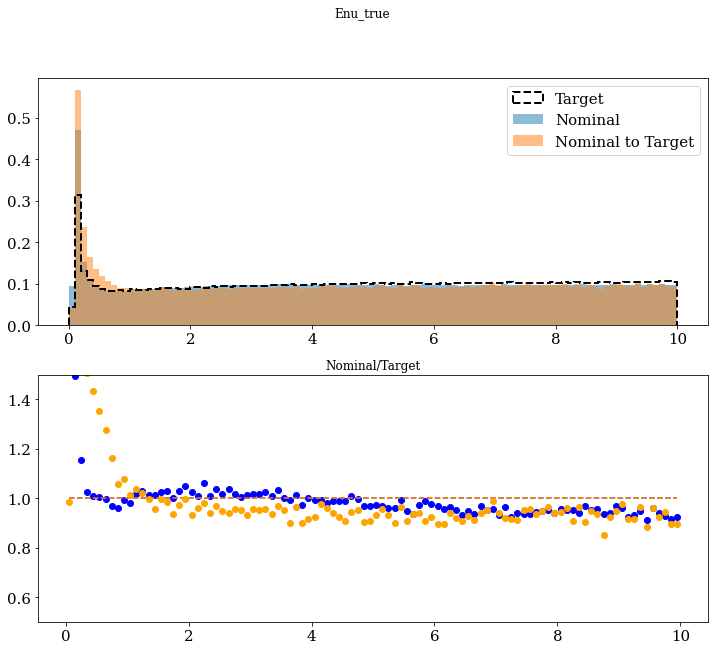

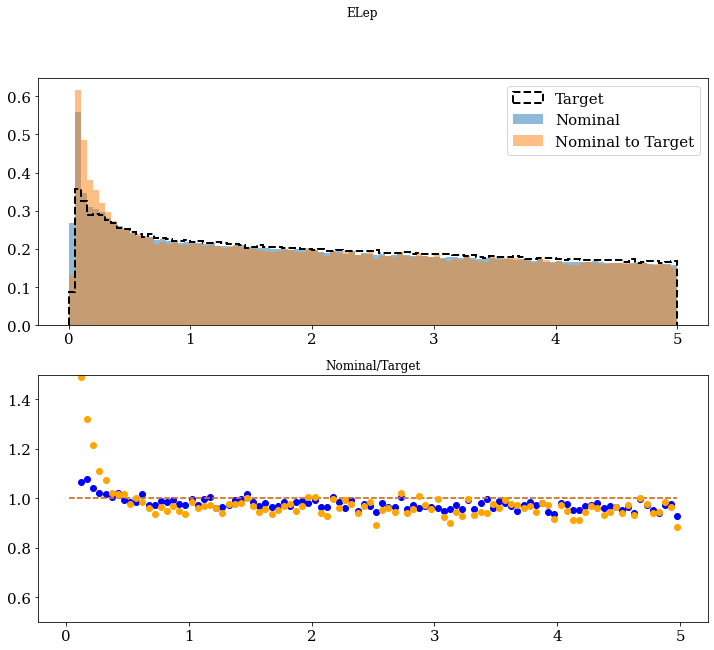

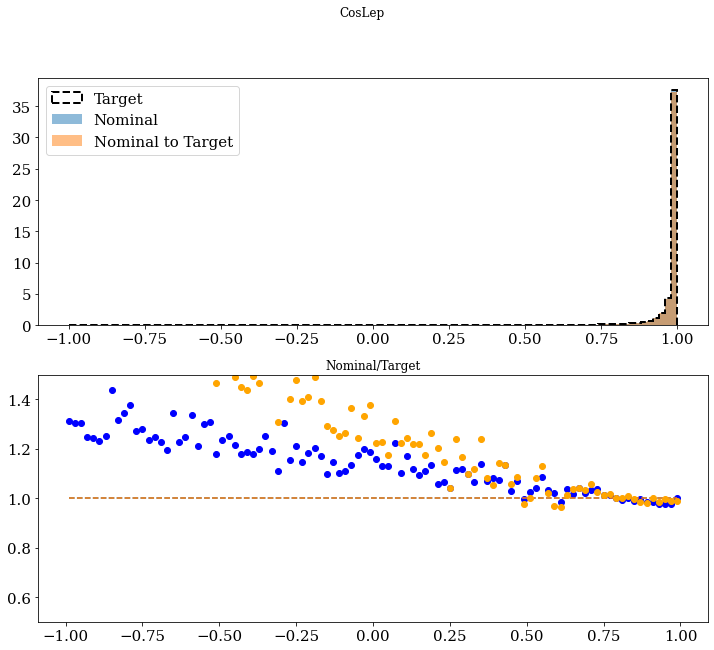

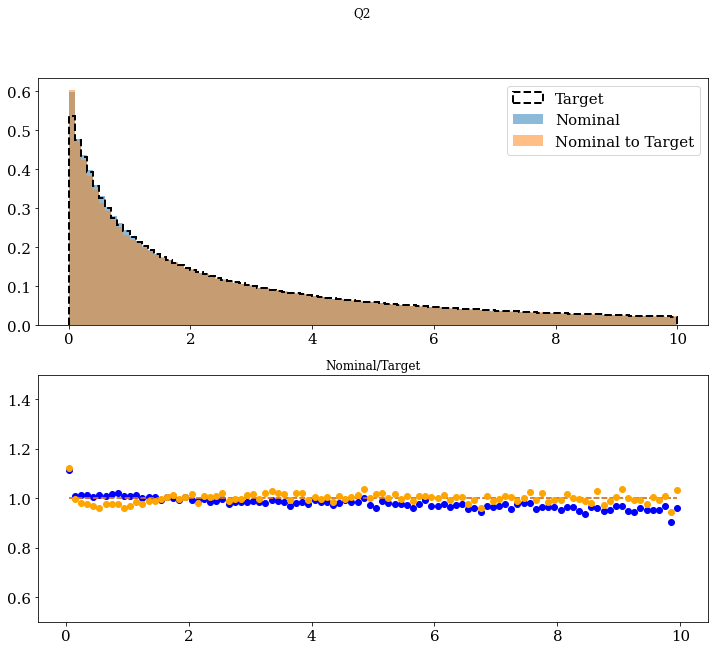

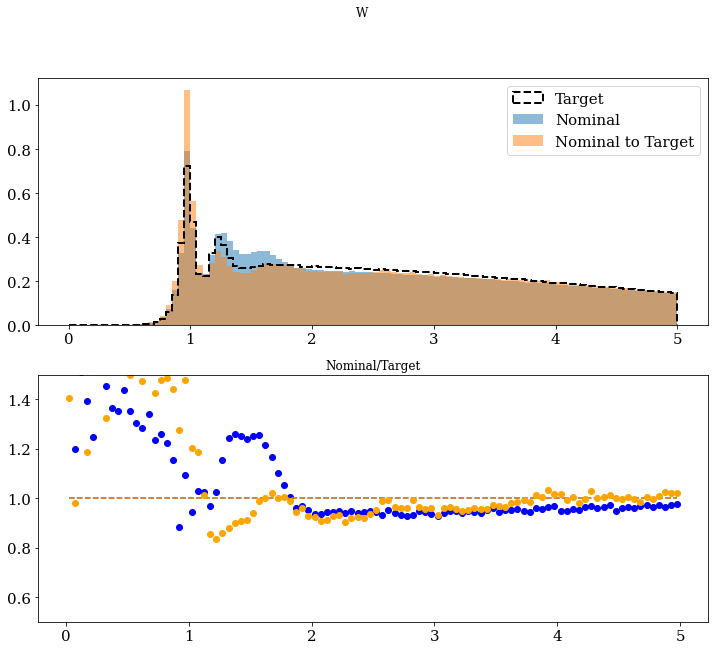

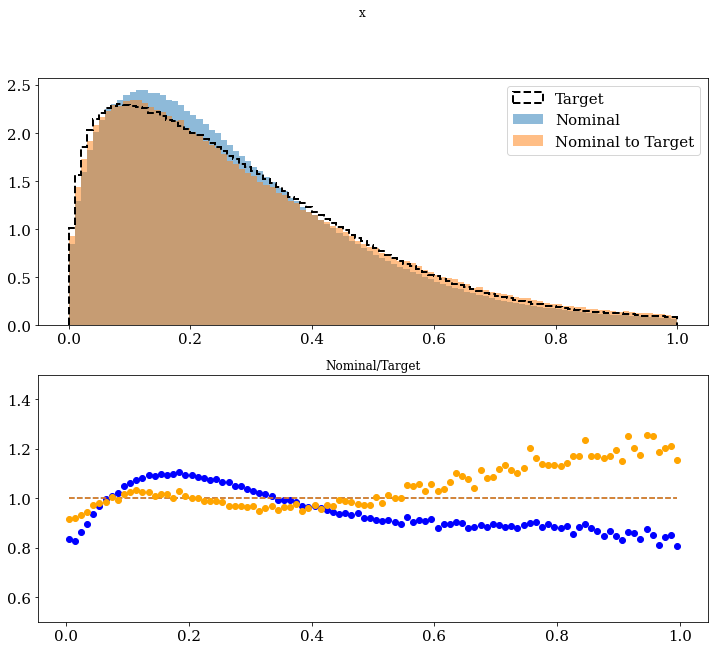

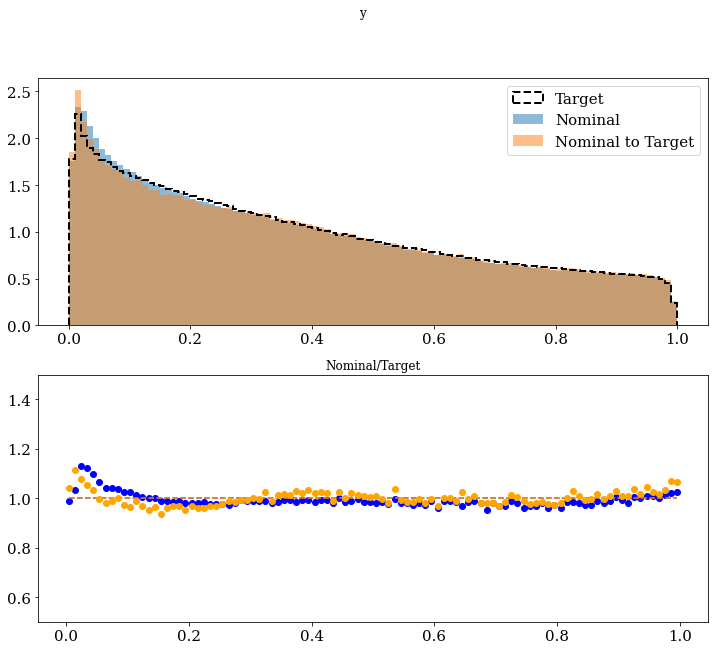

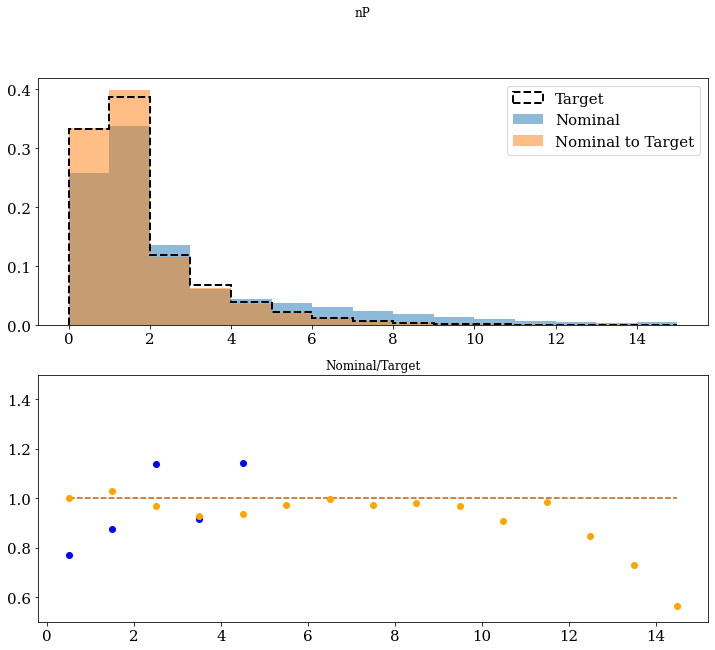

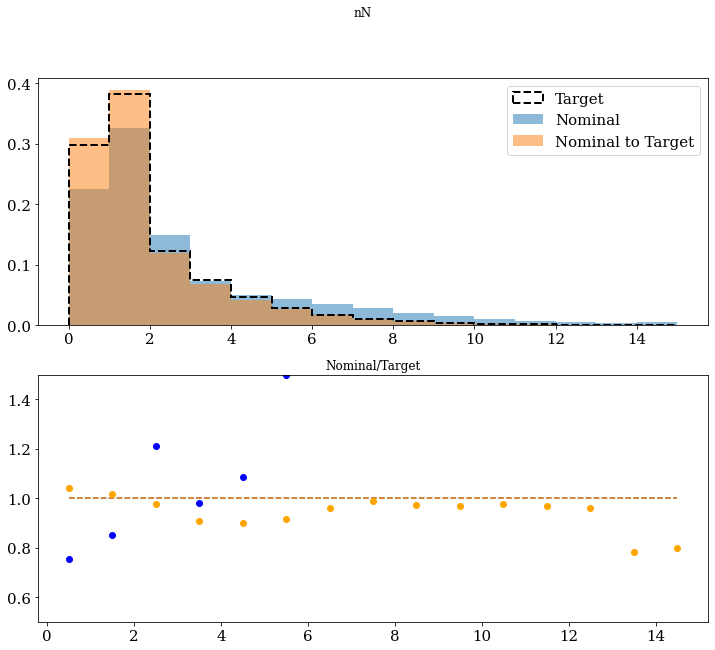

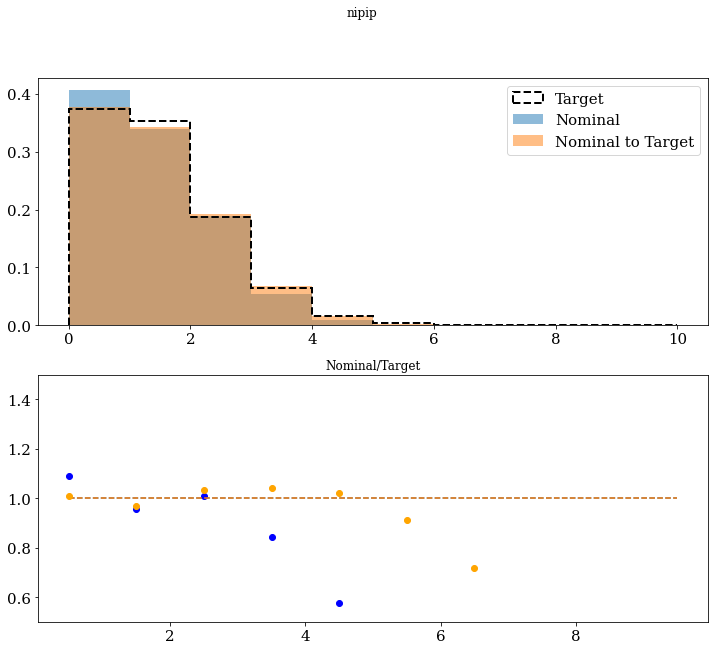

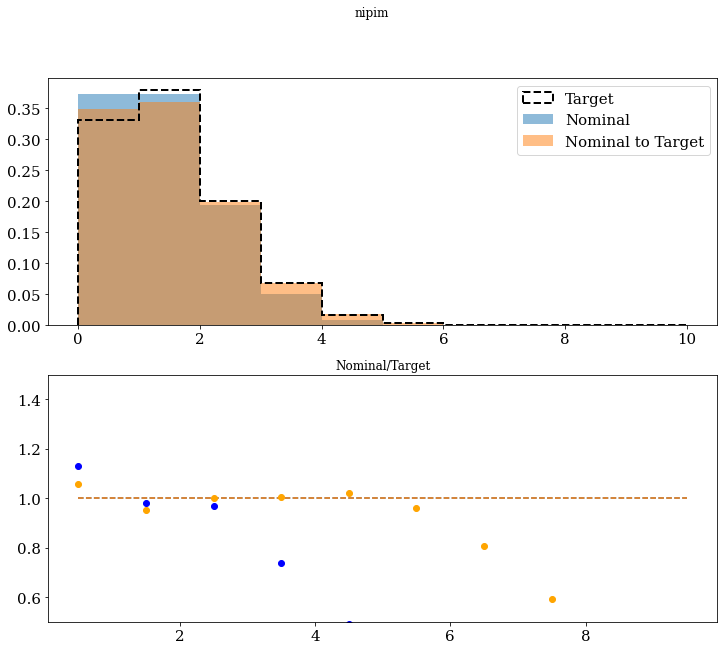

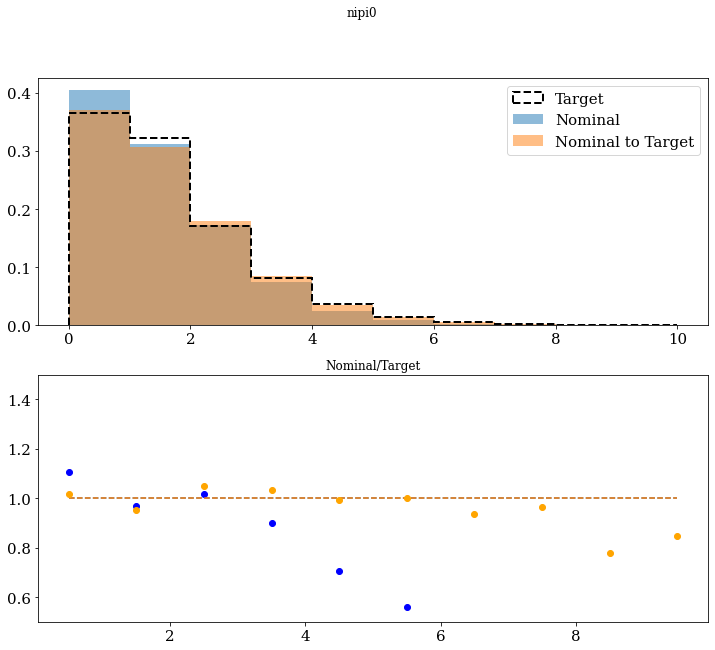

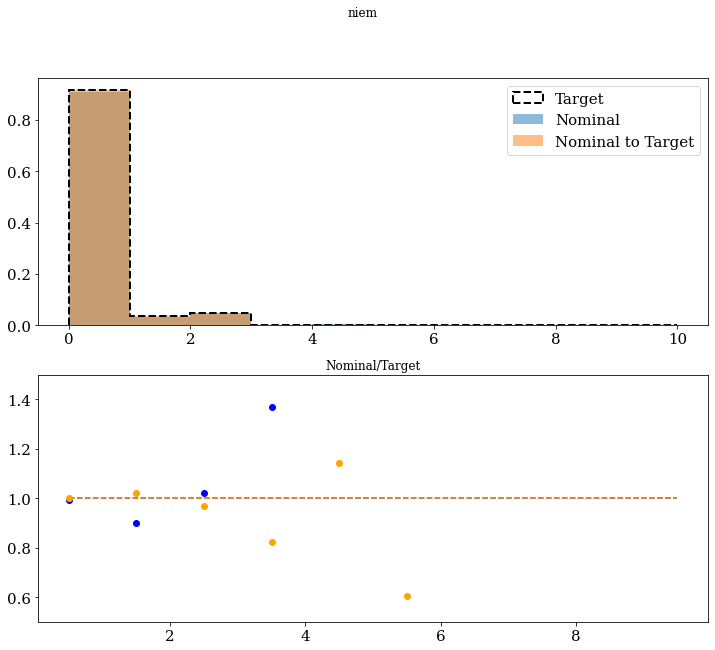

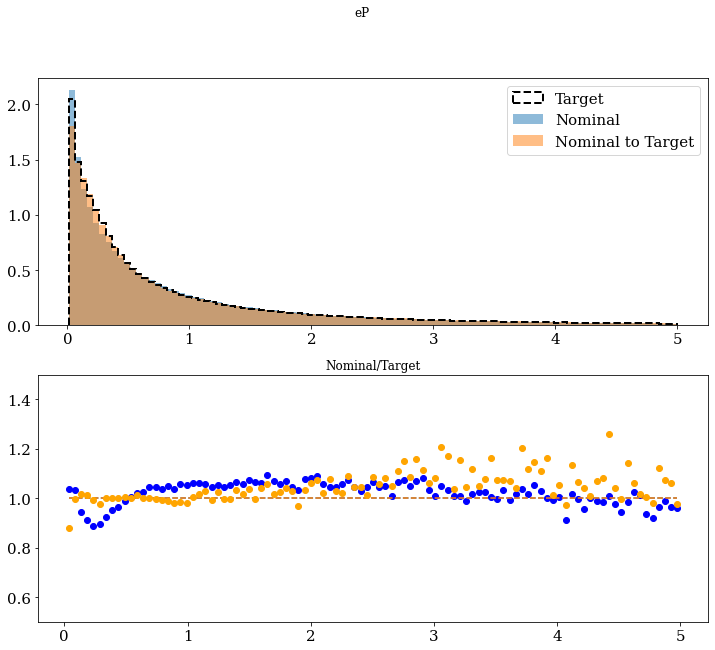

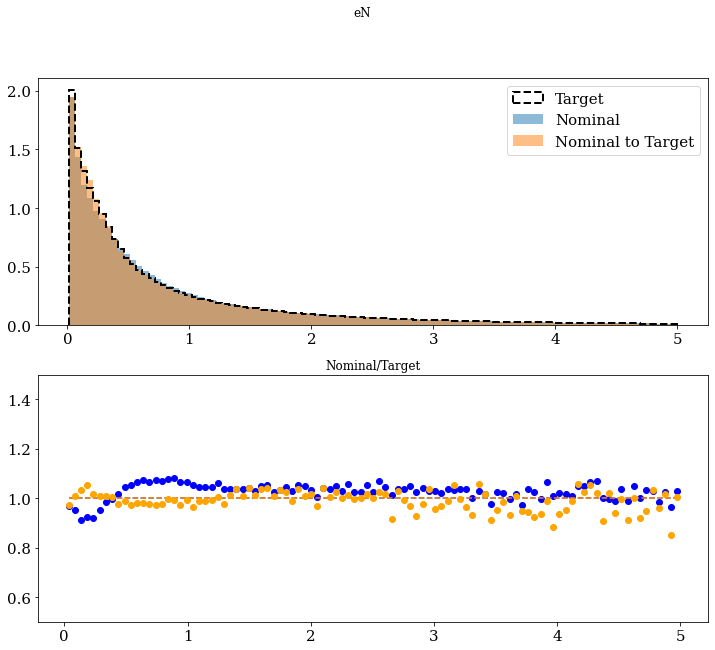

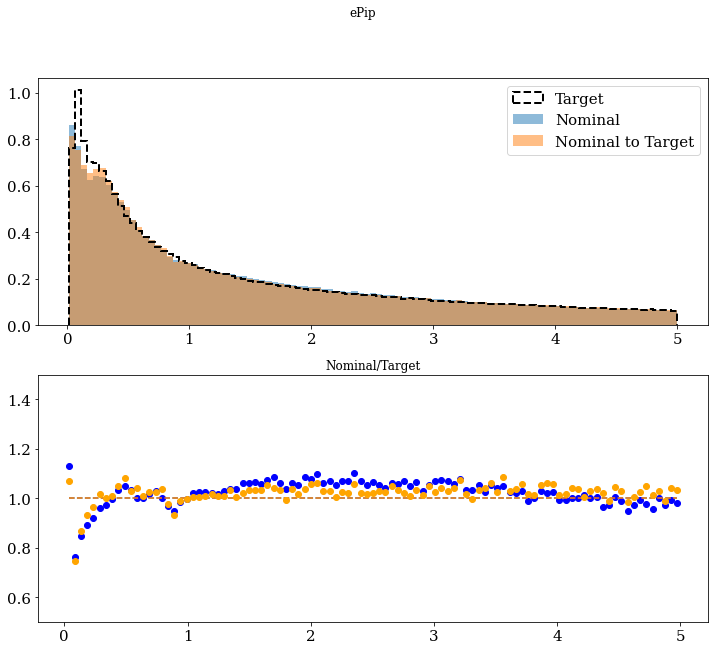

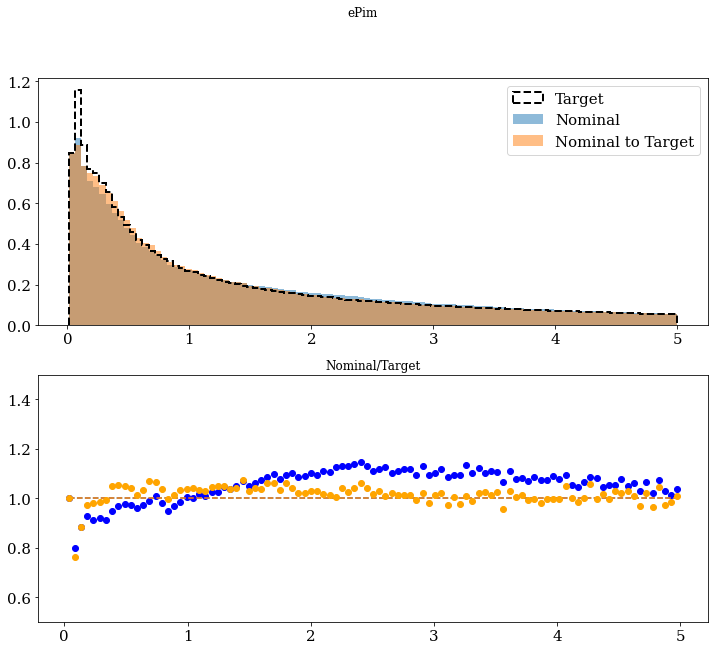

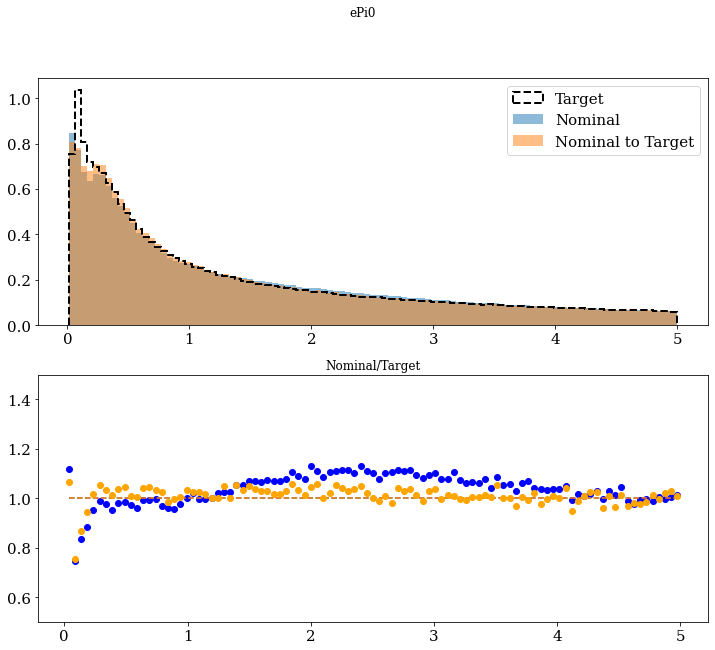

In [33]:
# Calculate weights for GENIE
plt.rcParams['figure.figsize'] = (12, 10)

neut, genie = load_feats_logits()
genie = genie[:len(neut)]
genie['weights'], genie['probas'] = calculate_weights(genie['logits'], weight_cap=1000)

for idx, variable in enumerate(col_names):
    range = (float(x_min[idx]), float(x_max[idx]))
    plot_distribution(genie[variable], neut[variable], genie['weights'], n_bins=int(n_bins[idx]), errorbars=False, density=True, range=range)
    plt.suptitle(variable)
    plt.show()

KeyError: 'probas'

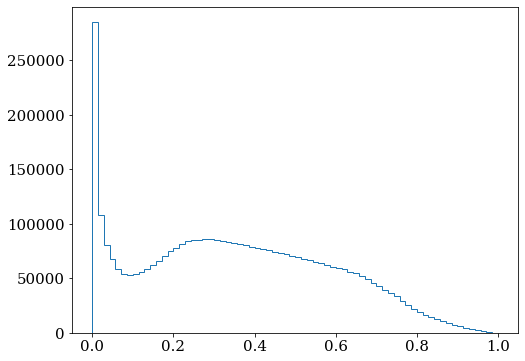

In [34]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.hist(genie['probas'], bins=70, histtype="step", label='GENIE')
plt.hist(neut['probas'], bins=70, histtype="step", label='NUWRO')
plt.legened()
plt.title('NN Output')
plt.ylim()

(0.0, 1632063.3)

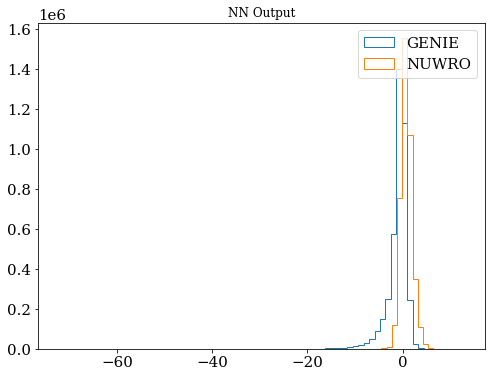

In [11]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.hist(np.array(genie['logits']), bins=70, histtype="step", label='GENIE')
plt.hist(np.array(neut['logits']), bins=70, histtype="step", label='NUWRO')
plt.legend()
plt.title('NN Output')
plt.ylim()

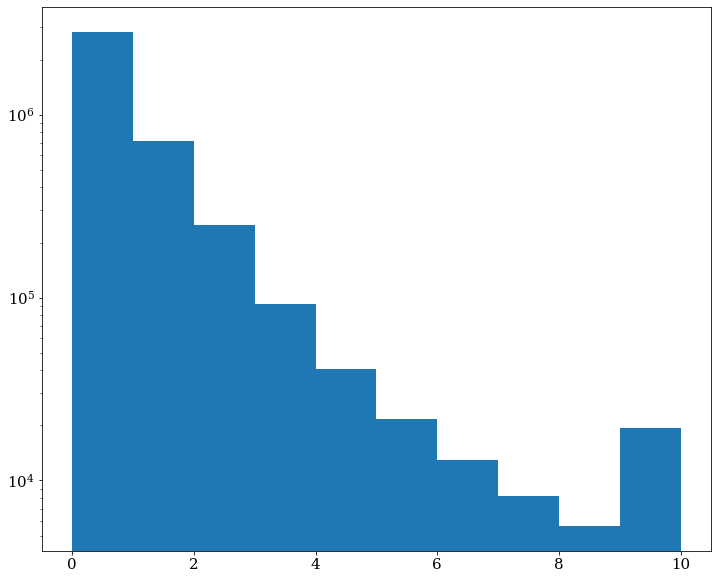

In [20]:
plt.hist(genie['weights'])
plt.yscale('log')

In [18]:
genie['weights'].isna().any()

False